<font size=6><b>Прогнозирование количества заказов такси</b></font>

<div style="border:solid GoldenRod 2px; padding: 20px; border-radius: 10px">

<b>Описание проекта</b><br>
Компания собрала исторические данные о заказах своих такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.<br>
<b>Цель</b><br>
Построить модель для такого предсказания. Значение метрики RMSE на тестовой выборке должно быть не больше 48.<br>
    
<b>Содержание</b>:<br>
1. Загрузка данных и их ресеплирование;
2. Анализ и создание признаков;
3. Обучение моделей;
4. Проверка лучшей модели на тестовой выборке;
5. Выводы.

## 1. Загрузка данных и ресемплирование

In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import optuna
from optuna.samplers import TPESampler
import shap

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

optuna.logging.set_verbosity(optuna.logging.WARNING)

RSTATE = 70707

In [2]:
df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<div style="border:solid GoldenRod 2px; padding: 20px; border-radius: 10px">

Исходные данные: 26496 записей (1 марта 2018 года по 31 августа 2018 года), шаг - 10 минут.

Сделаем ресемплирование данных по одному часу.

In [4]:
df_hours = df.resample('1H').sum()

In [5]:
display(df_hours.info())
display(df_hours.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## 2. Анализ и создание признаков

### 2.1 Базовый анализ

<div style="border:solid GoldenRod 2px; padding: 20px; border-radius: 10px">

Построим график изменения количества заказов такси во времени.

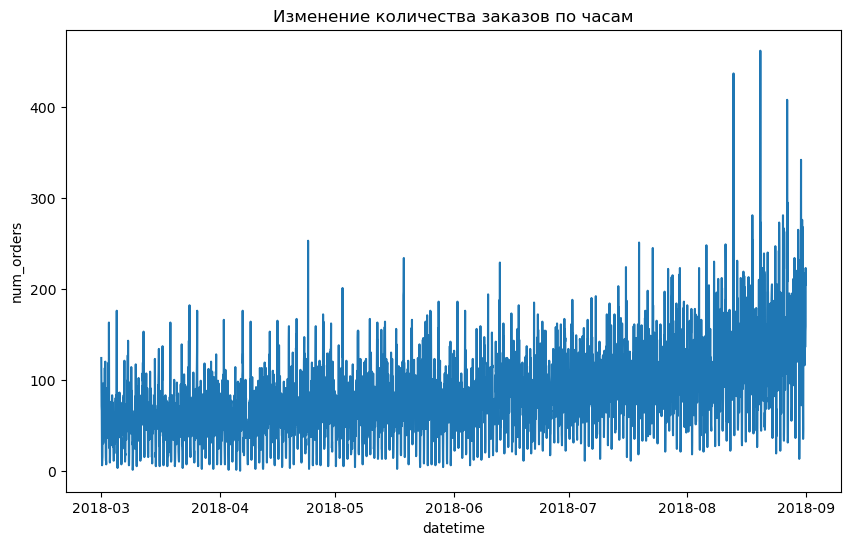

In [6]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=df_hours.index, y=df_hours['num_orders']).set(title='Изменение количества заказов по часам');

<div style="border:solid GoldenRod 2px; padding: 20px; border-radius: 10px">

Уже по этому графику видно, что количество заказов растёт.

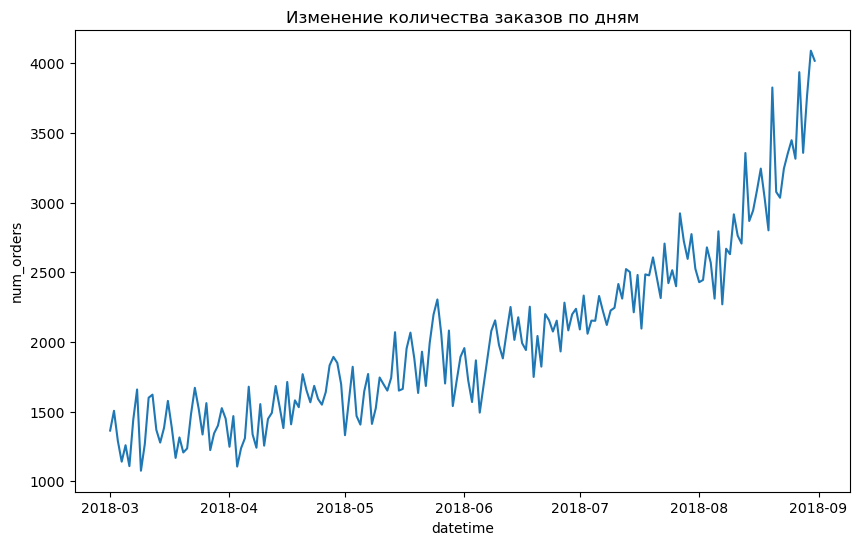

In [7]:
df_days = df.resample('1D').sum()
plt.figure(figsize=(10, 6))
sns.lineplot(x=df_days.index, y=df_days['num_orders']).set(title='Изменение количества заказов по дням');

<div style="border:solid GoldenRod 2px; padding: 20px; border-radius: 10px">

Рост количества заказов по дням ещё более очевиден. Хотя заметна и периодичность.

Построим гистограмму.

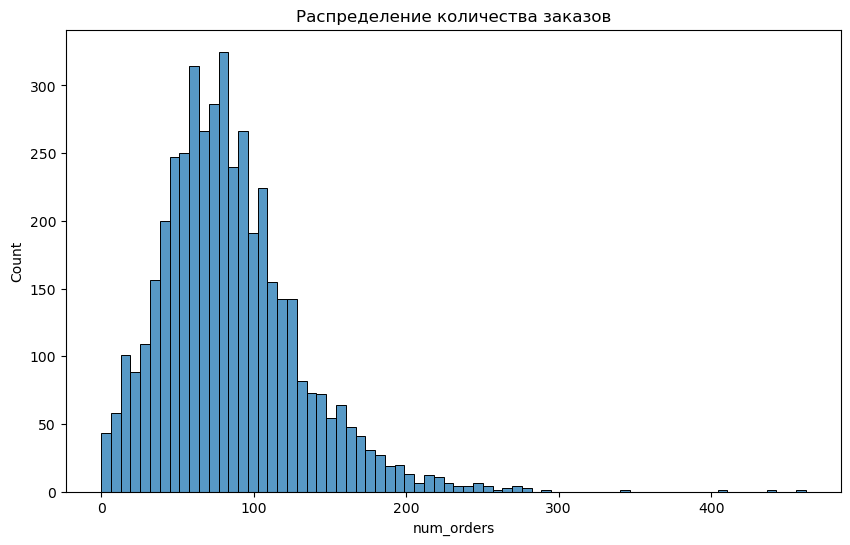

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(df_hours['num_orders']).set(title='Распределение количества заказов');

<div style="border:solid GoldenRod 2px; padding: 20px; border-radius: 10px">

Распределение должно хорошо описываться распределением Пуассона, приближающимся к нормальному. Заметен длинный правый хвост.

### 2.2 Стационарность и сезонность

<div style="border:solid GoldenRod 2px; padding: 20px; border-radius: 10px">

Сделаем декомпозицию изменения количества заказов во времени.

In [9]:
# функция принимает датафрейм и строит графики декомпозиции
def get_decomp(data):
    ts_decomp = seasonal_decompose(data['num_orders'])
    decomp = ts_decomp.trend, ts_decomp.seasonal, ts_decomp.resid
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 16))
    for i, ax in enumerate(axes):
        sns.lineplot(ax=ax, x=data.index, y=decomp[i])
        ax.set_title(f'{decomp[i].name.upper()}')
    plt.tight_layout()
    plt.show()

Декомпозиция по часам

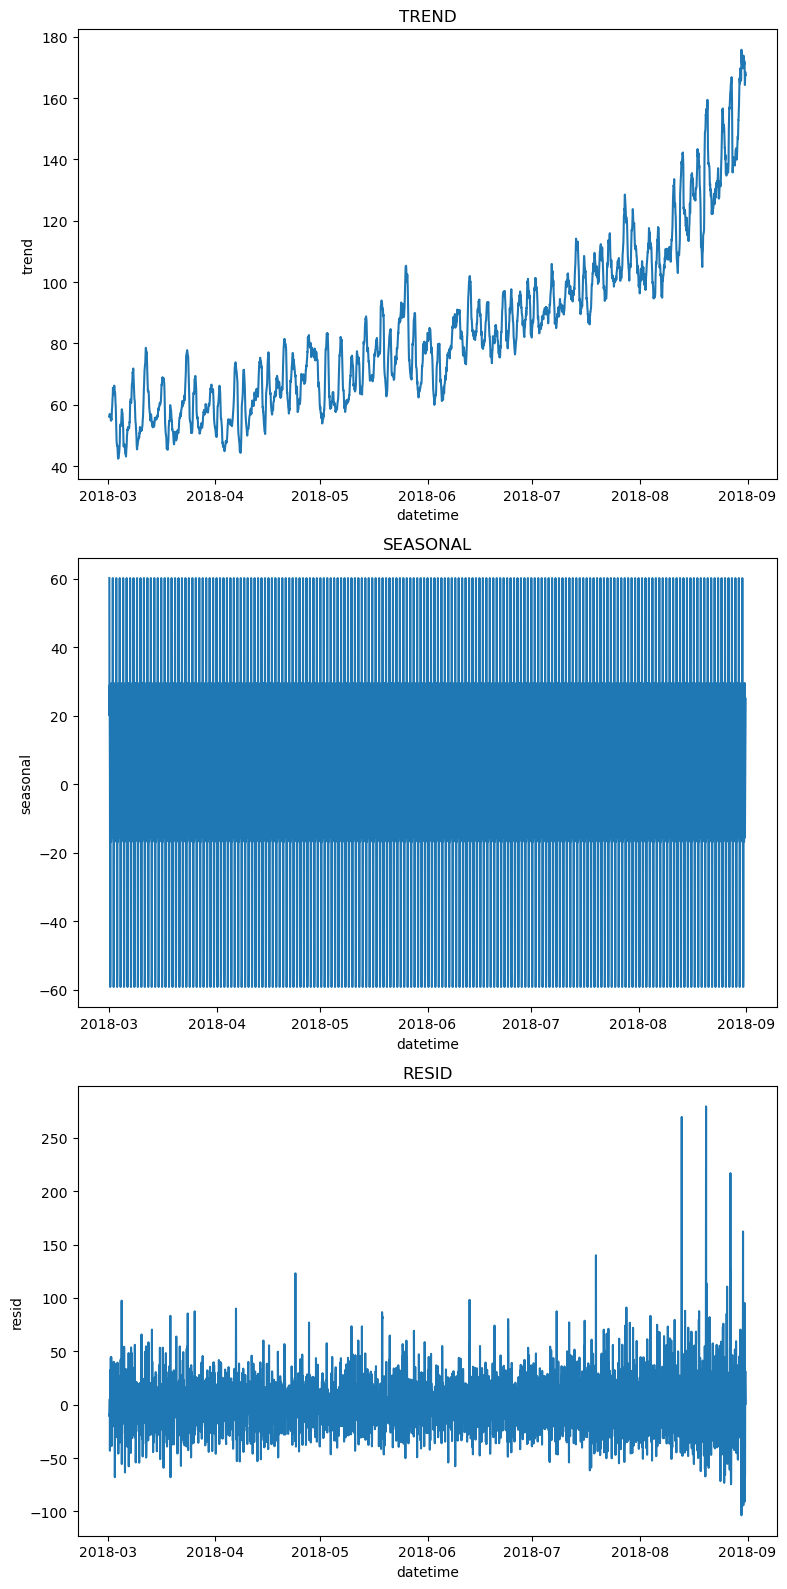

In [10]:
# графики декомпозиции (часы)
get_decomp(df_hours)

Декомпозиция по дням

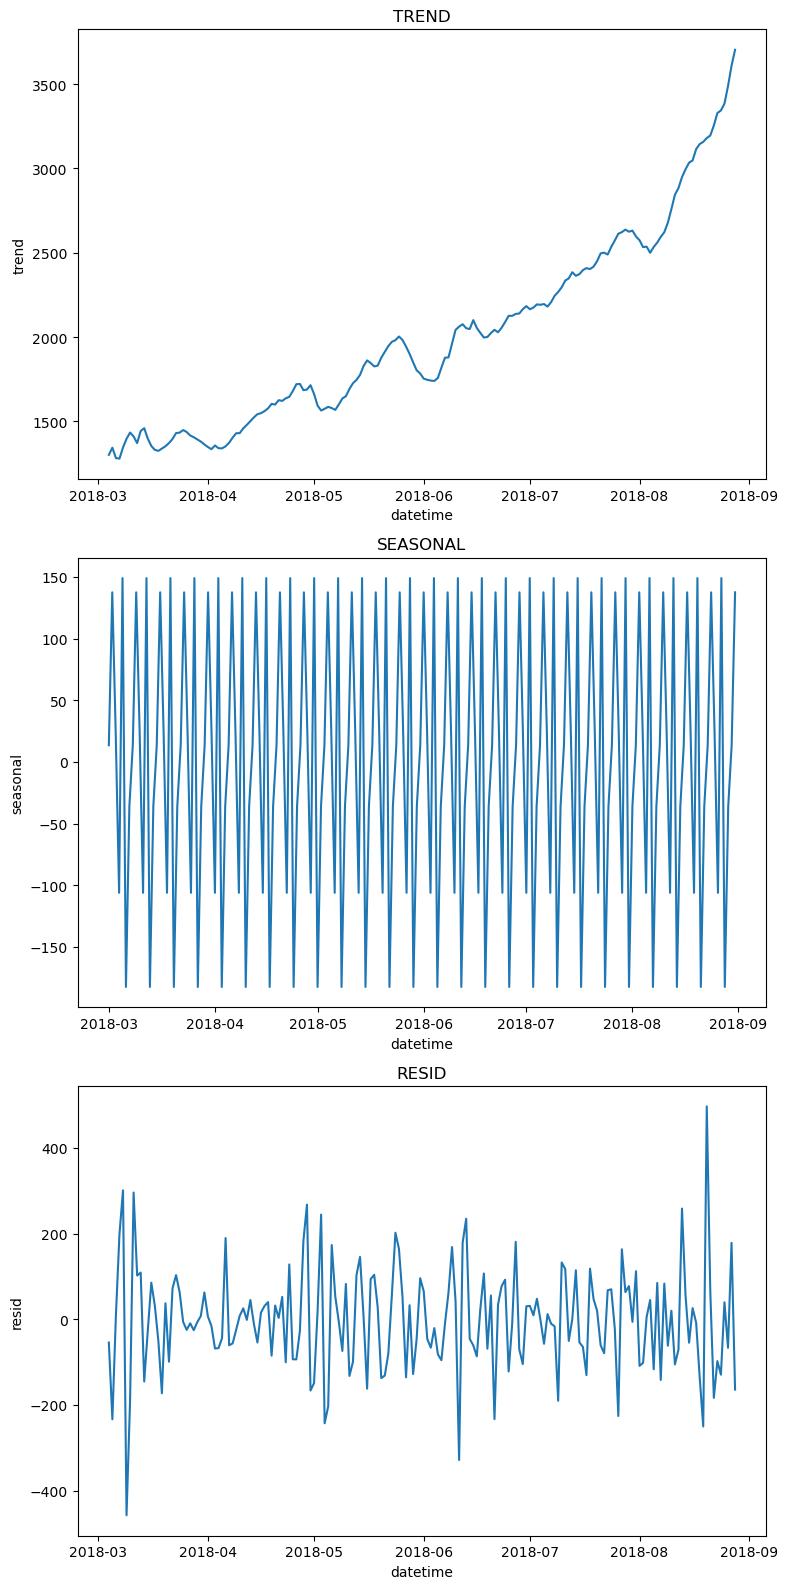

In [11]:
# графики декомпозиции (дни)
get_decomp(df.resample('1D').sum())

<div style="border:solid GoldenRod 2px; padding: 20px; border-radius: 10px">

На декомпозиции хорошо заметен тренд; периодичность сезонности связана, вероятно, с суточными и дневными изменениями; есть "случайные выбросы" в августе.

<div style="border:solid GoldenRod 2px; padding: 20px; border-radius: 10px">

Проверим временной ряд количества заказов на стационарность методом Дики-Фуллера для уровней значимости 1% и 5%.

**Нулевая гипотеза:** временной ряд нестационарный.<br>
<center>$H_0$(есть единичный корень)</center><br>

**Альтернативная гипотеза:** временной ряд стационарный.<br>
<center>$H_1$(нет единичного корня)</center>

In [12]:
adf_test = adfuller(df_hours)
print(f'adf-stat: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
print(f'Critical values: {adf_test[4]}')
if adf_test[0] > adf_test[4]['5%']:
    print('alpha = 5%: Нет оснований отвергнуть нулевую гипотезу: ряд нестационарен')
else:
    print('alpha = 5%: Есть основания отвергнуть нулевую гипотезу: ряд стационарен')
    if adf_test[0] > adf_test[4]['1%']:
        print('alpha = 1%: Нет оснований отвергнуть нулевую гипотезу: ряд нестационарен')
    else:
        print('alpha = 1%: Есть основания отвергнуть нулевую гипотезу: ряд стационарен')

adf-stat: -3.0689242890279482
p-value: 0.028940051402613506
Critical values: {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
alpha = 5%: Есть основания отвергнуть нулевую гипотезу: ряд стационарен
alpha = 1%: Нет оснований отвергнуть нулевую гипотезу: ряд нестационарен


<div style="border:solid GoldenRod 2px; padding: 20px; border-radius: 10px">

Временной ряд количества заказов может считаться **стационарным** при уровне статистической значимости **5%**.

### 2.3 Создание дополнительных признаков

<div style="border:solid GoldenRod 2px; padding: 20px; border-radius: 10px">

Так как год только один (2018), и нам при этом важно, в какое время суток происходят заказы такси, то создадим следующие признаки: месяц, день, день недели, час.

In [13]:
# функция создаёт признаки: календарные, "отстающие", скользящее среднее
def make_features(df, n_lags=0, n_roll=0):
    data = df.copy()
    # календарные
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    # "отстающие"
    if n_lags > 0:
        for i in range(1, n_lags + 1):
            data[f'lag_{i}'] = data['num_orders'].shift(i)
    # скользящее среднее (со сдвигом, чтобы не "смотреть в будущее")
    if n_roll > 0:
        data[f'rolling_mean_{n_roll}'] = data['num_orders'].shift().rolling(n_roll).mean()
    return data

<div style="border:solid GoldenRod 2px; padding: 20px; border-radius: 10px">

Создадим следующие признаки: 
* день недели
* час
* 5 отстающих признаков
* скользящее среднее по 30 часам.

In [14]:
df_hours1 = make_features(df_hours, n_lags=5, n_roll=30)
df_hours1.head(10)

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean_30
datetime,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN
2018-03-01 05:00:00,6,3,5,43.0,66.0,71.0,85.0,124.0,NaN
2018-03-01 06:00:00,12,3,6,6.0,43.0,66.0,71.0,85.0,NaN
2018-03-01 07:00:00,15,3,7,12.0,6.0,43.0,66.0,71.0,NaN
2018-03-01 08:00:00,34,3,8,15.0,12.0,6.0,43.0,66.0,NaN


<div style="border:solid GoldenRod 2px; padding: 20px; border-radius: 10px">

Рассмотрим зависимость количества заказов от дня недели и часа.

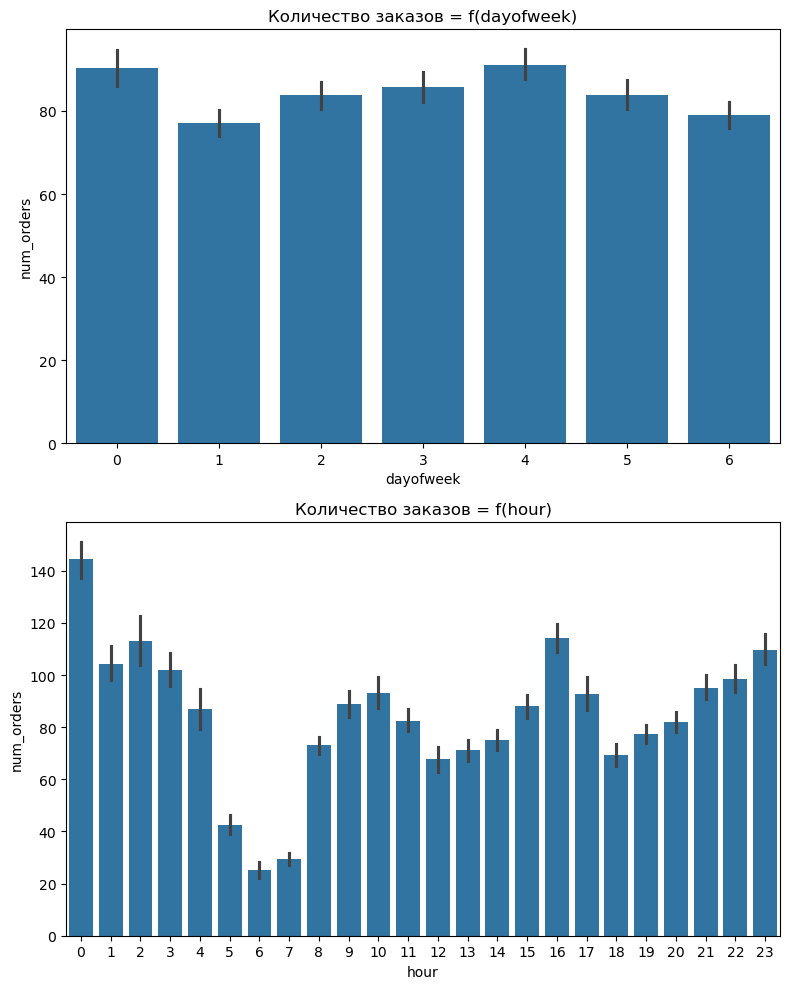

In [15]:
cols = df_hours1.columns[[1, 2]]
fig, axes = plt.subplots(nrows=len(cols), ncols=1, figsize=(8, 10))
for i, ax in enumerate(axes):
    sns.barplot(ax=ax, x=df_hours1[cols[i]], y=df_hours1['num_orders'])
    ax.set_title(f'Количество заказов = f({cols[i]})')
plt.tight_layout()
plt.show()

<div style="border:solid GoldenRod 2px; padding: 20px; border-radius: 10px">

На графиках видно:
* есть слабая зависимость от дня недели (в четверг и воскресенье больше заказов, а в понедельник меньше всего);
* количество заказов такси растёт к ночи, есть заметные пики в районе 9-10 часов и 16-17 часов (утренний и вечерний час пик), также заметен резкий спад ранним утром (вероятно, просто в это время нет самолётов).

Построим матрицу корреляции.

In [16]:
df_hours1.corr().style.background_gradient(vmin=-1, vmax=1, cmap='Spectral')

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean_30
num_orders,1.000000,-0.019628,0.004292,0.624138,0.465444,0.321173,0.248791,0.230489,0.547438
dayofweek,-0.019628,1.000000,0.000000,-0.027331,-0.029567,-0.029056,-0.028695,-0.028752,-0.004502
hour,0.004292,0.000000,1.000000,-0.076112,-0.120424,-0.154777,-0.146248,-0.123327,-0.036102
lag_1,0.624138,-0.027331,-0.076112,1.000000,0.623446,0.464959,0.320580,0.248332,0.592100
lag_2,0.465444,-0.029567,-0.120424,0.623446,1.000000,0.623151,0.464503,0.320169,0.615323
lag_3,0.321173,-0.029056,-0.154777,0.464959,0.623151,1.000000,0.622932,0.464285,0.630283
lag_4,0.248791,-0.028695,-0.146248,0.320580,0.464503,0.622932,1.000000,0.622791,0.633222
lag_5,0.230489,-0.028752,-0.123327,0.248332,0.320169,0.464285,0.622791,1.000000,0.623988
rolling_mean_30,0.547438,-0.004502,-0.036102,0.592100,0.615323,0.630283,0.633222,0.623988,1.000000


<div style="border:solid GoldenRod 2px; padding: 20px; border-radius: 10px">

Заметны логичные взаимосвязи между признаками, связанными по времени.

## 3. Обучение моделей

### 3.1 Разделение выборки

<div style="border:solid GoldenRod 2px; padding: 20px; border-radius: 10px">

Удалим образовавшиеся пустые значения.

In [17]:
df_hours1 = df_hours1.dropna()

<div style="border:solid GoldenRod 2px; padding: 20px; border-radius: 10px">

Разделим выборку на обучающую, валидационную и тестовую части в соотношении 8:1:1. Так как данные - это временной ряд, то валидационную и тестовую выборку возьмём с конца исходной выборки.

In [18]:
features = df_hours1.drop('num_orders', axis=1)
target = df_hours1['num_orders']

X_tr_vld, X_test, y_train_vld, y_test = train_test_split(features, target, shuffle=False, test_size=0.1)
X_train, X_valid, y_train, y_valid = train_test_split(X_tr_vld, y_train_vld, shuffle=False, test_size=0.111)
print(f'TRAIN: features {X_train.shape}, target {y_train.shape}')
print(f'VALID: features {X_valid.shape}, target {y_valid.shape}')
print(f'TEST : features {X_test.shape}, target {y_test.shape}')

TRAIN: features (3508, 8), target (3508,)
VALID: features (439, 8), target (439,)
TEST : features (439, 8), target (439,)


### 3.2 Подбор гиперпараметров и оценка качества

<div style="border:solid GoldenRod 2px; padding: 20px; border-radius: 10px">

Для моделирования выбраны три модели: Lasso(в качестве Baseline), RandomForest и LightGBM. Тюнинг гиперпараметров будем проводить с помощью библиотеки Optuna.

**Baseline: Lasso Linear Regression**

In [19]:
model = Lasso(random_state=RSTATE)
model.fit(X_train, y_train)
y_pred_valid = model.predict(X_valid)
print(f'Lasso (VALID): RMSE={mean_squared_error(y_valid, y_pred_valid, squared=False)}')

Lasso (VALID): RMSE=40.955016422083155


**Random Forest**

In [20]:
def rf_objective(trial, X_tr=X_train, y_tr=y_train, X_tst=X_valid, y_tst=y_valid):
    
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 2000),
        'max_depth': trial.suggest_int('max_depth', 1, 20)
    }    

    model = RandomForestRegressor(random_state=RSTATE,
                                  **param,
                                  n_jobs=-1
                                 )
    model.fit(X_train, y_train)
    y_pred_v = model.predict(X_valid)
    
    return mean_squared_error(y_valid, y_pred_v, squared=False)


rf_study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=RSTATE))

In [21]:
%%time
rf_study.optimize(rf_objective, n_trials=20)

print(f'RandomForest (VALID): RMSE={rf_study.best_value} params={rf_study.best_params}')

RandomForest (VALID): RMSE=32.05480128157543 params={'n_estimators': 228, 'max_depth': 18}
CPU times: total: 8min 15s
Wall time: 1min 16s


**LightGBM**

In [22]:
def lgbm_objective(trial, X_tr=X_train, y_tr=y_train, X_tst=X_valid, y_tst=y_valid):
    
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'num_leaves': trial.suggest_int('num_leaves', 2, 1024),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.10, log=False, step=0.001),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0, log=False, step=0.1),
        #'max_bin': range(170, 256, 5), #[180]
        #'subsample': np.arange(0.1, 1.01, 0.1),
        #'feature_fraction': np.arange(0.1, 1.01, 0.2),
        #'min_data_in_leaf': range(10, 101, 10)
        #'cat_l2': [0.0, 5.0, 10.0, 20.0],
        #'cat_smooth': [0.0, 5.0, 10.0, 20.0],
        #'is_unbalance': [False, True],
        #'extra_trees': [False, True]
    }    

    model = LGBMRegressor(random_state=RSTATE,
                          n_jobs=-1, 
                          verbose=-1, 
                          **param
                         )
    model.fit(X_train, y_train)
    y_pred_v = model.predict(X_valid)
    
    return mean_squared_error(y_valid, y_pred_v, squared=False)


lgbm_study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=RSTATE))

In [23]:
%%time
lgbm_study.optimize(lgbm_objective, n_trials=100)

print(f'LightGBM (VALID): RMSE={lgbm_study.best_value} params={lgbm_study.best_params}')

LightGBM (VALID): RMSE=30.5510028754751 params={'n_estimators': 1862, 'max_depth': 6, 'num_leaves': 858, 'learning_rate': 0.015, 'reg_alpha': 0.4}
CPU times: total: 8min 10s
Wall time: 1min 2s


<div style="border:solid GoldenRod 2px; padding: 20px; border-radius: 10px">

Лучшее качество на валидации показала модель LightGBM (**RMSE=30.551**), её и выберем для проверки качества на тестовой выборке.

## 4. Проверка модели на тестовой выборке

<div style="border:solid GoldenRod 2px; padding: 20px; border-radius: 10px">

Обучим модель на полной обучающей выборке.

In [24]:
lgbreg = LGBMRegressor(random_state=RSTATE,
                       **lgbm_study.best_params,
                       n_jobs=-1, 
                       verbose=-1
                      )
lgbreg.fit(X_tr_vld, y_train_vld)

LGBMRegressor(learning_rate=0.015, max_depth=6, n_estimators=1862, n_jobs=-1,
              num_leaves=858, random_state=70707, reg_alpha=0.4, verbose=-1)

<div style="border:solid GoldenRod 2px; padding: 20px; border-radius: 10px">

Оценим качество обученной модели на тестовой выборке.

In [25]:
y_pred = lgbreg.predict(X_test)
print(f'Лучшая модель: RMSE = {mean_squared_error(y_test, y_pred, squared=False)}')

Лучшая модель: RMSE = 42.90757867712596


<div style="border:solid GoldenRod 2px; padding: 20px; border-radius: 10px">

Полученное значение **RMSE=42.907** удовлетворяет критерию задания.

Сравним это значение метрики с качеством тривиальной модели (прогноз предыдущим значением ряда).

In [26]:
y_dummy = y_test.shift(fill_value=y_train.iloc[-1])
print(f'Тривиальная модель: rmse = {mean_squared_error(y_test, y_dummy, squared=False)}')

Тривиальная модель: rmse = 58.93278283721631


<div style="border:solid GoldenRod 2px; padding: 20px; border-radius: 10px">

Метрика тривиальной модели оказалась хуже. Выбранная модель адекватна.  
Построим графики временных рядов реальных данных и прогноза.

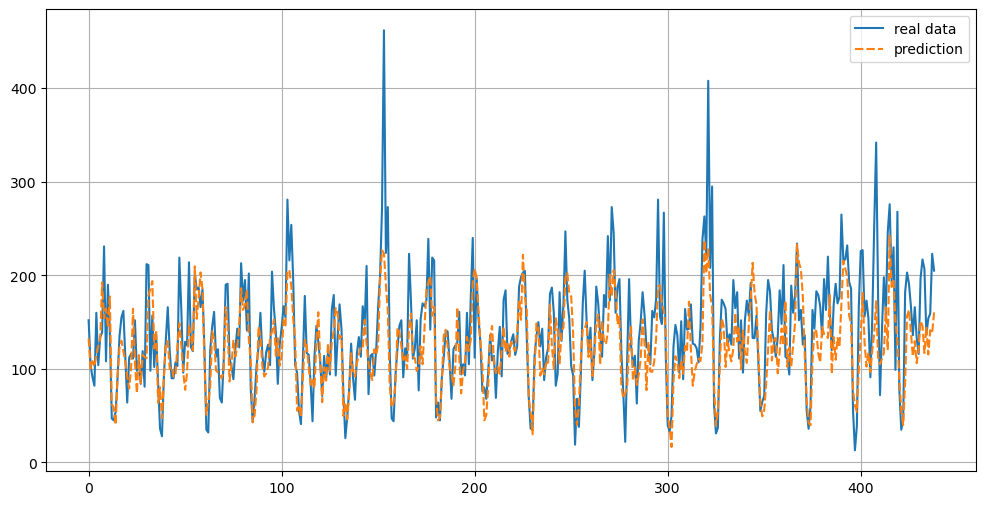

In [27]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(pd.DataFrame([y_test.values, y_pred], index=['real data', 'prediction']).T, ax=ax)
plt.grid();

<div style="border:solid GoldenRod 2px; padding: 20px; border-radius: 10px">

Как видно из двух наложенных друг на друга графиков временных рядов основная часть особенностей была спрогнозирована верно, за исключением амплитуды некоторых выбросов.

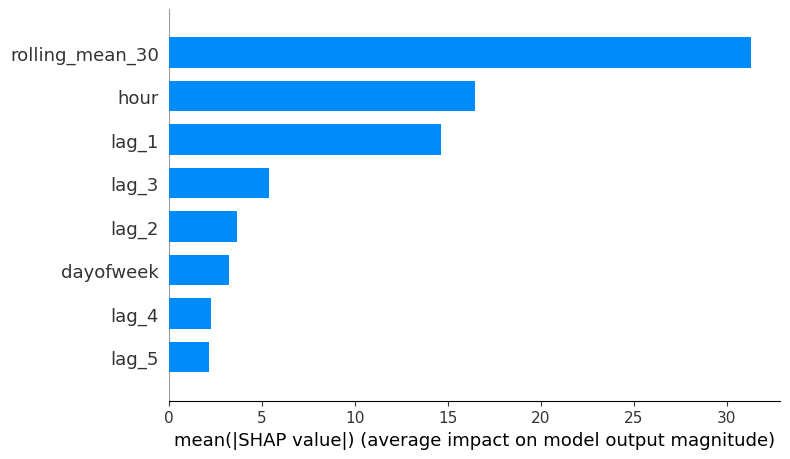

In [28]:
explainer = shap.Explainer(lgbreg)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

<div style="border:solid GoldenRod 2px; padding: 20px; border-radius: 10px">

Наибольшее влияние на результат прогноза оказал созданный признак "rolling_mean_30"(скользящее среднее за тридцать часов), а так же час и лаг в один час.

## 5. Выводы

<div style="border:solid GoldenRod 2px; padding: 20px; border-radius: 10px">

1. Исходные данные (с 10-минутной дискретизацией) были ресемплированы с разрядкой в 1 час;
2. Заметны тренд на рост количества заказов, суточные колебания, сильные выбросы количества заказов в августе;
3. Были созданы признаки: день недели, час, пять "лага", 30-ти часовое скользящее среднее;
4. С каждым месяцем количество заказов растёт, количество заказов слабо зависит от дня недели, заметны колебания числа заказов в течение суток (ночью чаще, так как общественный транспорт ночью не ходит);
5. Выборка была разделена, прогноз должен производиться для последних 10% данных временного ряда;
6. Были обучены четыре модели: Lasso, решающее дерево, случайный лес и LightGBM, для них подобраны гиперпараметры;
7. Лучшая модель на валидации (LightGBM) была проверена на тестовой выборке: метрика **RMSE = 42.925**, при этом это значение лучше, чем при тривиальном прогнозе предыдущим значением ряда;
8. Лучшая модель справляется со своей задачей и удовлетворяет критерию задания.